<a href="https://colab.research.google.com/github/mostafa-ja/LLM_from_scratch/blob/main/Let's_build_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to build the model based on [karpathy's tutorial video ](https://www.youtube.com/watch?v=l8pRSuU81PU)

More explanation also [here](https://devshahs.medium.com/build-gpt-with-me-implementing-gpt-from-scratch-step-by-step-b2efe4e2f7e0), [here ](https://medium.com/@tusharmadaan/reproducing-gpt-2-124m-key-insights-and-techniques-cd8899864bbe) and [here ](https://towardsdatascience.com/line-by-line-lets-reproduce-gpt-2-section-1-b26684f98492/)

Tokenizer for GPT [here ](https://tiktokenizer.vercel.app/)




# Import data

In [1]:
# Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-03-26 13:09:24--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.009s  

2025-03-26 13:09:24 (114 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
# let's look at the first 200 characters
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [9]:
lower_text = text.lower()
print(lower_text[:200])

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you are all resolved rather to die than to famish?

all:
resolved. resolved.

first citizen:
first, you


In [10]:
# here are all the unique characters that occur in this text
lower_chars = sorted(list(set(lower_text)))
lower_vocab_size = len(lower_chars)
print(''.join(lower_chars))
print(lower_vocab_size)


 !$&',-.3:;?abcdefghijklmnopqrstuvwxyz
39


In [11]:
# Open a file in write mode and save the text
with open("lower_input.txt", "w", encoding="utf-8") as file:
    file.write(lower_text)

print("lower_input saved successfully!")

lower_input saved successfully!


# New Section

In [35]:
import sentencepiece as spm

# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="input.txt",
  input_format="text",
  # output spec
  model_prefix="tok512", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=512,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=False,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)


In [36]:
sp = spm.SentencePieceProcessor()
sp.load('tok512.model')
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
print(vocab)

[['<unk>', 0], ['<s>', 1], ['</s>', 2], ['▁t', 3], ['he', 4], ['▁a', 5], ['ou', 6], ['▁s', 7], ['▁m', 8], ['▁w', 9], ['in', 10], ['re', 11], ['ha', 12], ['▁the', 13], ['nd', 14], ['▁b', 15], ['is', 16], ['or', 17], ['▁f', 18], ['▁I', 19], ['er', 20], ['ll', 21], ['it', 22], ['on', 23], ['▁d', 24], ['▁c', 25], ['▁n', 26], ['▁l', 27], ['▁y', 28], ['es', 29], ['en', 30], ['▁th', 31], ['ar', 32], ['▁h', 33], ['▁o', 34], ['▁to', 35], ['▁you', 36], ['▁p', 37], ['▁T', 38], ['hat', 39], ['▁A', 40], ['▁he', 41], ['st', 42], ['ve', 43], ['ot', 44], ['▁and', 45], ['ow', 46], ['ing', 47], ['▁of', 48], ['an', 49], ['om', 50], ['▁g', 51], ['at', 52], ['▁be', 53], ['▁W', 54], ['se', 55], ['▁my', 56], ['▁in', 57], ['▁ha', 58], ['ce', 59], ['le', 60], ['ay', 61], ['ld', 62], ['ir', 63], ['et', 64], ['ed', 65], ['ut', 66], ['▁B', 67], ['▁me', 68], ['im', 69], ['▁S', 70], ['ith', 71], ['▁not', 72], ['▁H', 73], ['ch', 74], ['▁that', 75], ['▁is', 76], ['▁M', 77], ['gh', 78], ['▁And', 79], ['▁for', 80], ['▁

In [49]:
import sentencepiece as spm

# train a sentencepiece model on it
# the settings here are (best effort) those used for training Llama 2
import os

options = dict(
  # input spec
  input="lower_input.txt",
  input_format="text",
  # output spec
  model_prefix="tok512_lower", # output filename prefix
  # algorithm spec
  # BPE alg
  model_type="bpe",
  vocab_size=512,
  # normalization
  normalization_rule_name="identity", # ew, turn off normalization
  remove_extra_whitespaces=False,
  input_sentence_size=200000000, # max number of training sentences
  max_sentence_length=4192, # max number of bytes per sentence
  seed_sentencepiece_size=1000000,
  shuffle_input_sentence=True,
  # rare word treatment
  character_coverage=0.99995,
  byte_fallback=False,
  # merge rules
  split_digits=True,
  split_by_unicode_script=True,
  split_by_whitespace=True,
  split_by_number=True,
  max_sentencepiece_length=16,
  add_dummy_prefix=True,
  allow_whitespace_only_pieces=True,
  # special tokens
  unk_id=0, # the UNK token MUST exist
  bos_id=1, # the others are optional, set to -1 to turn off
  eos_id=2,
  pad_id=-1,
  # systems
  num_threads=os.cpu_count(), # use ~all system resources
)

spm.SentencePieceTrainer.train(**options)

In [50]:
sp_lower = spm.SentencePieceProcessor()
sp_lower.load('tok512_lower.model')
vocab_lower = [[sp_lower.id_to_piece(idx), idx] for idx in range(sp_lower.get_piece_size())]
print(vocab_lower)

[['<unk>', 0], ['<s>', 1], ['</s>', 2], ['▁t', 3], ['he', 4], ['▁a', 5], ['▁s', 6], ['▁w', 7], ['▁i', 8], ['ou', 9], ['▁m', 10], ['▁b', 11], ['ha', 12], ['re', 13], ['▁the', 14], ['nd', 15], ['in', 16], ['or', 17], ['▁f', 18], ['▁c', 19], ['▁o', 20], ['er', 21], ['▁l', 22], ['ll', 23], ['▁d', 24], ['▁n', 25], ['hi', 26], ['▁y', 27], ['en', 28], ['▁p', 29], ['st', 30], ['▁to', 31], ['▁and', 32], ['ar', 33], ['▁you', 34], ['▁he', 35], ['on', 36], ['▁g', 37], ['th', 38], ['es', 39], ['ing', 40], ['▁th', 41], ['▁of', 42], ['▁no', 43], ['hat', 44], ['an', 45], ['ve', 46], ['om', 47], ['▁wi', 48], ['▁be', 49], ['▁ha', 50], ['se', 51], ['▁my', 52], ['ce', 53], ['▁hi', 54], ['ow', 55], ['▁in', 56], ['at', 57], ['le', 58], ['▁that', 59], ['ri', 60], ['ed', 61], ['ay', 62], ['et', 63], ['▁for', 64], ['ut', 65], ['▁k', 66], ['ld', 67], ['▁is', 68], ['▁we', 69], ['ir', 70], ['us', 71], ['▁me', 72], ['▁e', 73], ['▁h', 74], ['ke', 75], ['▁not', 76], ['▁with', 77], ['ch', 78], ['gh', 79], ['oo', 80],

In [51]:
input = "you are all resolved rather to die than to famish? before we proceed any further, hear me speak."
ids = sp.encode(input)
ids_lower = sp_lower.encode(input)

print(len(input))

print(len(ids))
print([sp.id_to_piece(idx) for idx in ids])

print(len(ids_lower))
print([sp_lower.id_to_piece(idx) for idx in ids_lower])

96
36
['▁you', '▁are', '▁all', '▁re', 's', 'ol', 've', 'd', '▁r', 'ather', '▁to', '▁d', 'ie', '▁than', '▁to', '▁f', 'am', 'ish', '?', '▁be', 'fore', '▁we', '▁pro', 'ce', 'ed', '▁an', 'y', '▁f', 'ur', 't', 'her', ',', '▁hear', '▁me', '▁speak', '.']
35
['▁you', '▁are', '▁all', '▁re', 's', 'ol', 've', 'd', '▁r', 'ather', '▁to', '▁d', 'ie', '▁than', '▁to', '▁f', 'am', 'ish', '?', '▁be', 'fore', '▁we', '▁pro', 'ce', 'ed', '▁an', 'y', '▁f', 'ur', 'ther', ',', '▁hear', '▁me', '▁speak', '.']


# Attention Mechanism

## Uniform Attention Mechanism

### Introduction
When processing a sequence of tokens, it is essential to consider the context provided by past tokens. The order in which tokens appear carries meaningful information. However, in a naive approach, each token is processed independently, meaning there is no interaction between them. Our goal is to allow each token to communicate selectively with past tokens while ensuring that future tokens remain inaccessible, as they are yet to be predicted.

### Input Representation
We define our input tensor as:

```
X.shape = (B, T, C) = (4, 8, 32)
```
where:
- **B** is the batch size,
- **T** is the number of tokens in the context window,
- **C** is the number of channels representing each token.

For instance, in a batch, we have **8 tokens**, each described by **32 channels**. Initially, these tokens do not interact with one another, meaning that the model processes them independently. Our objective is to enable communication among tokens while restricting each token’s access to **only previous tokens and itself** (causal attention). This ensures that we do not leak future information, which is crucial for autoregressive models.

### Naive Approach: Uniform Averaging
A simple way to incorporate past information is to take the average of all accessible past tokens. For example, if **t=5**, we could compute the average representation of tokens **1, 2, 3, 4, 5**. However, this approach is inefficient because it treats all past tokens **equally**, ignoring the varying degrees of relevance different tokens might have.

### Weighted Attention with a Masked Matrix
We introduce a **weight tensor** that assigns uniform importance levels to past tokens. The weight matrix is designed such that each token can only attend to past tokens and itself while ignoring future tokens.

#### Step 1: Creating the Masked Weight Matrix
We construct a **lower triangular matrix** that masks out future tokens:

```python
import torch
import torch.nn.functional as F

T = 8  # Number of tokens in the context window
tril = torch.tril(torch.ones(T, T))  # Lower triangular matrix

weight = torch.zeros((T, T))  # Initialize weights to zero
weight = weight.masked_fill(tril == 0, float('-inf'))  # Mask future tokens
weight = F.softmax(weight, dim=-1)  # Apply softmax to get probabilities
```

- The **lower triangular matrix** ensures that each token only considers past tokens.
- Applying **SoftMax** normalizes the values so that the sum of weights for each row equals **1**.
- Any masked positions (future tokens) are assigned **-inf**, which results in a softmax output of **zero**, effectively preventing any influence from future tokens.

#### Step 2: Applying the Attention Weights
Once we have the weight matrix, we apply it to our input tensor `X`:

```python
output = weight @ X  # (T, T) @ (B, T, C) --> (B, T, C)
```
This operation aggregates the past information for each token in a weighted manner.

### Example of the Weight Matrix
For **T=8**, an example of the computed weight matrix is:

```
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]])
```
- Each row corresponds to a token in the sequence.
- The sum of each row is **1**, ensuring that each token aggregates its past context without altering the total contribution.
- The **fifth row (t=5)**, for instance, distributes attention over tokens **1, 2, 3, 4, 5**.

### Summary
- The **attention mechanism** allows each token to selectively aggregate information from past tokens while ignoring future ones.
- A **triangular masking** approach ensures causality by preventing tokens from seeing future information.
- **SoftMax normalization** is used to distribute attention weights effectively.
- This weight matrix is the same across all samples in a batch since it depends only on the token positions within the context window.

This forms the basis for **self-attention mechanisms** used in modern deep learning architectures like **Transformers**.



In [2]:
# consider the following toy example:
import torch
import torch.nn.functional as F

# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [4]:
# use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
print(wei)
out = wei @ x
print(out.shape)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
torch.Size([4, 8, 2])


## Understanding the Self-Attention Mechanism

Self-attention is a crucial component in Transformer models, allowing them to understand context by dynamically weighting the importance of different words in a sequence. Let's break it down step by step.

#### The Problem: Ambiguity in Word Meaning

Each word (token) in a sentence is initially represented as a vector, called an **embedding**, which captures its general meaning. However, words can have different meanings depending on context. For example, the word "model" could refer to an **AI model** or a **fashion model**. To resolve this ambiguity, we need a mechanism that considers surrounding words and extracts the correct meaning. This is where **self-attention** comes in—it enables each word to focus more on contextually relevant words.

### How Self-Attention Works
Self-attention operates using three key vectors derived from each token:
- **Query (Q)**: Represents what this word is looking for in others (e.g., a noun might look for its describing adjective).
- **Key (K)**: Represents what this word has to offer to others (e.g., an adjective offers descriptive details).
- **Value (V)**: Represents the actual content of the word (e.g., the actual meaning of the word).


These vectors are generated by multiplying the input embeddings with three learned weight matrices:

$$
Q = X \times W_q, \quad K = X \times W_k, \quad V = X \times W_v
$$

where:

- $X$ is the input word embeddings.
- $W_q, W_k, W_v$ are learned weight matrices that transform embeddings into their respective Q, K, and V vectors.

### Computing Attention Scores

The attention mechanism determines **how much each word should focus on others** in the sentence. This is done by computing a **similarity score** between the Query of one word and the Keys of all words:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) \times V
$$

- The dot product **$QK^T$** gives a similarity score between words.
- The result is scaled by $\sqrt{d_k}$ (where $d_k$ is the dimension of the key vector) to prevent large values from dominating.
- **Softmax** ensures that attention weights sum to 1, making them interpretable as probabilities.
- The attention scores determine how much of each value (V) contributes to the final representation.



### Example

Let’s break down the sentence **"The cat sat on the mat"** and provide realistic representations for **Attention Weights** and **Value (V)** vectors in the context of self-attention. I’ll also explain the role of each word and how they might interact. Since we’re simulating a Transformer-like model, I’ll make some reasonable assumptions about embeddings and attention behavior, keeping it intuitive yet grounded in how such models typically work.

### Setup and Assumptions
- **Sentence:** "The cat sat on the mat" (6 tokens, including a period for simplicity).
- **Vector Size:** Let’s assume 4-dimensional vectors for Q, K, and V (in reality, they’re often 64 or 512 dims, but 4 keeps it manageable).
- **Process:** Each word gets Q, K, and V vectors. Attention weights come from Q and K interactions, and V vectors are combined using those weights.
- **Goal:** Show how V contributes to the output and interpret each word’s role.

I’ll assign plausible V vectors based on linguistic roles (e.g., nouns, verbs, articles) and estimate attention weights based on likely dependencies in this simple sentence.

---

### Step 1: Define Roles of Each Word
Before diving into numbers, let’s understand what each word does:
1. **"The" (determiner):** Specifies the noun "cat." It’s a helper, pointing to something definite.
2. **"cat" (noun, subject):** The main actor, the entity doing the sitting.
3. **"sat" (verb):** The action, central to the sentence, linking "cat" to its location.
4. **"on" (preposition):** Indicates position, connecting "sat" to "mat."
5. **"the" (determiner):** Specifies "mat," another helper for the object.
6. **"mat" (noun, object):** The location or recipient of the action.

In self-attention, each word looks at all others to build context. For example, "cat" might focus on "sat" (its action) and "The" (its specifier), while "sat" might focus on "cat" (subject) and "on" (where it happened).

---

### Step 2: Assign Plausible Value (V) Vectors
These are hypothetical but inspired by how embeddings capture meaning (e.g., nouns might emphasize entity features, verbs action features), consider that V calculates based on input X and learned weights Wv. Let’s use a 4D vector where dimensions loosely represent:
- [entity, action, relation, modifier] (just for intuition, not strict).

- **"The" (first):** V = [0.5, 0.0, 0.2, 0.3]  
  - Mild entity boost (specifies something), some relation/modifier role.
- **"cat":** V = [1.0, 0.1, 0.2, 0.0]  
  - Strong entity (noun), tiny action/relation hint.
- **"sat":** V = [0.2, 1.0, 0.3, 0.0]  
  - Strong action (verb), some entity/relation from subject and object.
- **"on":** V = [0.1, 0.2, 1.0, 0.1]  
  - Strong relation (preposition), minor entity/action.
- **"the" (second):** V = [0.5, 0.0, 0.2, 0.3]  
  - Same as first "The," specifying "mat."
- **"mat":** V = [1.0, 0.1, 0.3, 0.0]  
  - Strong entity (noun), slight relation hint (it’s the object).

These V vectors are the "content" each word offers—its semantic contribution.

---

### Step 3: Estimate Attention Weights
Attention weights come from $$\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
$$ also Q and K calculated based on input X learned wights of Wq and Wk. We’ll estimate weights based on linguistic intuition. Each row sums to 1.0, representing how much each word attends to others.

| **Query Word** | **The1** | **cat** | **sat** | **on** | **the2** | **mat** |
|----------------|----------|---------|---------|--------|----------|---------|
| **The1**       | 0.40     | 0.40    | 0.10    | 0.05   | 0.03     | 0.02    |
| **cat**        | 0.30     | 0.20    | 0.40    | 0.05   | 0.03     | 0.02    |
| **sat**        | 0.05     | 0.35    | 0.25    | 0.25   | 0.05     | 0.05    |
| **on**         | 0.02     | 0.05    | 0.35    | 0.20   | 0.15     | 0.23    |
| **the2**       | 0.03     | 0.02    | 0.05    | 0.15   | 0.35     | 0.40    |
| **mat**        | 0.02     | 0.05    | 0.10    | 0.25   | 0.30     | 0.28    |

#### Interpretation of Weights:
- **"The1":** Focuses on itself (0.40) and "cat" (0.40), as it specifies the subject.
- **"cat":** Attends to "sat" (0.40) for its action and "The1" (0.30) for specificity.
- **"sat":** Balances "cat" (0.35, subject), itself (0.25), and "on" (0.25, location).
- **"on":** Looks at "sat" (0.35, the action it modifies) and "mat" (0.23, its object).
- **"the2":** Focuses on "mat" (0.40) and itself (0.35), specifying the object.
- **"mat":** Attends to "on" (0.25, its position) and "the2" (0.30, its specifier).

These weights reflect dependency-like relationships, close to what a trained model might learn.

---

### Step 4: Compute Output for One Word (Example: "cat")
Using the attention weights for "cat" and the V vectors:
- Weights: [0.30, 0.20, 0.40, 0.05, 0.03, 0.02]
- V vectors: From above.

Output = Σ (weight × V):
- 0.30 × [0.5, 0.0, 0.2, 0.3] = [0.15, 0.0, 0.06, 0.09] (The1)
- 0.20 × [1.0, 0.1, 0.2, 0.0] = [0.20, 0.02, 0.04, 0.0] (cat)
- 0.40 × [0.2, 1.0, 0.3, 0.0] = [0.08, 0.40, 0.12, 0.0] (sat)
- 0.05 × [0.1, 0.2, 1.0, 0.1] = [0.005, 0.01, 0.05, 0.005] (on)
- 0.03 × [0.5, 0.0, 0.2, 0.3] = [0.015, 0.0, 0.006, 0.009] (the2)
- 0.02 × [1.0, 0.1, 0.3, 0.0] = [0.02, 0.002, 0.006, 0.0] (mat)

Sum = [0.47, 0.432, 0.292, 0.104]

**New "cat" representation:** [0.47, 0.432, 0.292, 0.104]
- Stronger entity (0.47) and action (0.432) from "cat" and "sat," with some relation (0.292) from "on."

---

### Step 5: Role of Each Word via V and Attention
- **"The1":** Its V ([0.5, 0.0, 0.2, 0.3]) gives "cat" specificity (entity + modifier). Attention to "cat" (0.40) reinforces this.
- **"cat":** Its V ([1.0, 0.1, 0.2, 0.0]) is the subject’s core. It pulls action from "sat" (0.40 weight).
- **"sat":** Its V ([0.2, 1.0, 0.3, 0.0]) is the action hub, shared with "cat" and "on," shaping the event.
- **"on":** Its V ([0.1, 0.2, 1.0, 0.1]) links "sat" to "mat," adding relational context.
- **"the2":** Its V ([0.5, 0.0, 0.2, 0.3]) specifies "mat," aiding the object’s clarity.
- **"mat":** Its V ([1.0, 0.1, 0.3, 0.0]) is the object, enriched by "on" and "the2."

---

### Reality Check
In a real Transformer:
- Vectors would be higher-dimensional (e.g., 512), capturing nuanced features.
- Attention weights would come from trained Q-K dot products, not intuition.
- Multi-head attention would split focus across different aspects (e.g., syntax vs. semantics).

Still, this approximation mirrors how V carries meaning (e.g., action from "sat") and attention weights prioritize relationships (e.g., "cat" to "sat").

---

### Closing
The V vectors are the "what" each word contributes—its semantic essence—while attention weights decide "how much" of each V matters. For "cat," the output blends its identity with its action ("sat"), tuned by helpers like "The" and "on." Does this bring it closer to reality for you? Want to tweak something or explore another word’s output? Let me know!

## Self-attention


### **Attention Layer in GPT-2**  

GPT-2 employs a **causal self-attention mechanism**, which ensures that each token in the sequence can only attend to the tokens that precede it. This is what makes the model "causal"—it prevents information from leaking from future tokens, thereby maintaining the autoregressive nature of the model, which is crucial for generating coherent text.  

At a high level, this attention mechanism can be viewed as a **message-passing process** on a graph, where each token is treated as a node. As the model processes a sequence, it **updates each token’s representation (embedding) by aggregating relevant information from previous tokens**. This is accomplished using **key, query, and value vectors**:  

- **Query**: Represents the token making the request for information.  
- **Key**: Represents the token providing information.  
- **Value**: The actual information that is shared between tokens.  

Each token compares its query with the keys of all preceding tokens to determine how much attention it should pay to them. The resulting weighted sum of values updates the token’s embedding, allowing it to incorporate contextual information dynamically.  

#### **Multi-Head Attention**  
GPT-2 employs **multiple attention heads**, each initialized differently on different subspaces of the input embedding. This design allows different heads to **capture distinct aspects of relationships between tokens**:  
- Some heads may specialize in **syntactic dependencies**, helping the model understand grammatical structures.  
- Other heads may focus on **semantic relationships**, enabling a better grasp of meaning across words.  

By processing multiple attention heads in parallel, the model **enhances its understanding of long-range dependencies and improves contextual coherence** across sequences. This multi-headed structure contributes significantly to GPT-2’s ability to generate fluent and contextually relevant text.  



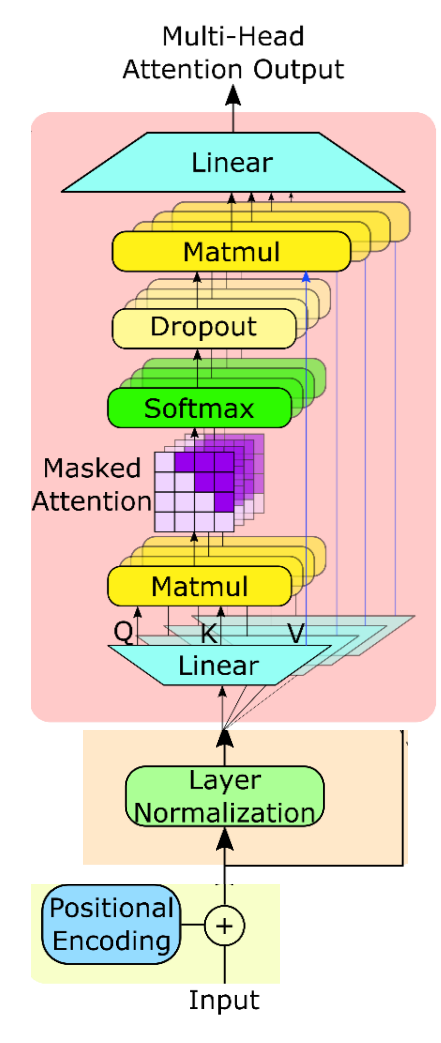

In [6]:
# self-attention (a single Head)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16  # it takes 32 channels information for a token and gives 16 channels info for just a specific head
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

Each linear layer (nn.Linear) transforms the input tensor from the original channel size (C) to a specified head_size without bias. We do this because we want to project the original input tensor x, with dimensions (B, T, C), into three separate spaces—keys (k), queries (q), and values (v)—each with a reduced dimensionality specified by the hyperparameter head_size.

**Why We Don’t Use Bias in Self-Attention**
*   Each linear layer in self-attention serves only as a projection from input features (C) to the head_size dimension. Unlike activation functions (like ReLU), where bias can help with shifting the output, the self-attention mechanism does not require a bias shift
*   Self-attention works on relative importance, making absolute shifts (caused by bias) irrelevant.




**Notes:**
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space (awareness of position of the token in the context). Attention simply acts over a set of vectors. This is why we need to positionally encode tokens (which is added to inouts).
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling (attention paper has both encoder and decoder and designed for translation not language model).
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

### **What is Scaled Attention?**  

In Transformer-based models like GPT-2, attention mechanisms compute scores to determine how much focus each token should place on others in the sequence. However, if these scores become too large, they can lead to issues such as **vanishing or exploding gradients**, which can slow down learning or make optimization unstable.  

To address this, Transformers use **scaled attention**, a technique that involves dividing the computed attention scores by the square root of the dimensionality of the key vectors.  

#### **Why Scaling?**  
The raw attention scores are computed as follows:  

$$
\text{Attention Score} = \frac{QK^T}{\sqrt{d_k}}
$$

where:  
- $( Q )$ (Query) represents the current token’s vector.  
- $( K )$ (Key) represents the vectors of the tokens being attended to.  
- $( d_k )$ is the dimensionality of the key vectors.  
-
$( QK^T )$ computes dot products between queries and keys, determining how similar they are.  

Since the dot product grows with the size of $( d_k )$, larger values could cause the **softmax function** to produce extremely sharp probability distributions. This leads to:  
- **Small gradients**, making it hard for the model to learn effectively.  
- **Attention scores dominated by a few large values**, reducing the model’s ability to distribute attention properly.  

To counteract this, we **divide by $( \sqrt{d_k} )$** to normalize the scores. This **prevents extreme values, stabilizes training, and ensures better gradient flow**.

#### **Effect of Scaling**  
- **Without scaling:** The softmax function would produce very peaked distributions, where a few tokens dominate attention.  
- **With scaling:** The scores remain balanced, ensuring a more **even spread of attention** across relevant tokens.  

This simple yet crucial adjustment makes Transformers like GPT-2 more **stable and efficient** during training, leading to better performance on large-scale language modeling tasks.


In [7]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

print(k.var())
print(q.var())
print(wei.var())

tensor(1.0449)
tensor(1.0700)
tensor(1.0918)


In [8]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [9]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [11]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*0.01, dim=-1) # converges to a uniform vector

tensor([0.2000, 0.1994, 0.2004, 0.1994, 0.2008])